# **인공지능 모델 학습**

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import pickle
from pickle import dump
import warnings
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [102]:
# 난수의 시드값 지정
np.random.seed(1)
tf.random.set_seed(1)

# 기본 하이퍼파라미터 지정
learning_rate = 0.001 # optimizer에 지정할 학습률
N_EPOCHS = 300 # 학습 횟수
N_BATCH = 64 # batch size

In [103]:
# 데이터 불러오기 _ pd.read_csv('경로/파일명')
data = pd.read_csv('/content/공기질데이터.csv')

#데이터 확인
print(data.shape)
data.head(2)

(60321, 17)


,dateTime,PM10,PM25,co1,temp,humi,co2,voc,hcho,volt,amp,external_dateTime,external_PM10,external_PM25,external_co1,external_temp,external_humi
0,2022-09-07 07:34:00,5.00,4.00,0.0,23.60,43.6,985.0,34.00,100.0,10.0,170.0,2022-09-07 07:34:00,32.60,13.86700,0.34300,17.11300,97.0
1,2022-09-07 07:34:30,5.75,4.75,0.0,23.65,43.7,985.0,36.25,100.0,11.0,155.5,2022-09-07 07:34:30,32.55,13.85025,0.34225,17.11475,97.0


In [104]:
# 소수점 첫째 자리까지 수치들을 반올림

columns = ['PM25', 'external_PM10', 'external_PM25', 'external_humi', 'external_temp', 'external_co1']

for col in columns:
  column = col
  where = 1  # 소수점 몇번째 자리까지 반올림할 것인지

  data[column]= round(data[column], where)


In [105]:
# 데이터 이상치 제거

def get_outlier(df=None, column=None, weight=1.5):

  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
# oulier_idx = get_outlier(df=df, column='A', weight=1.5)
# df.drop(outlier_idx, axis=0, inplace=True)

for col in columns:
  outlier_idx = get_outlier(df=data, column=col, weight=1.5)
  print('아래의 이상치 데이터를 삭제했습니다.')
  print(outlier_idx)
  data.drop(outlier_idx, axis=0, inplace=True)

아래의 이상치 데이터를 삭제했습니다.
Int64Index([14540, 28868, 28878, 29304, 29504, 40181, 40182, 40183, 45969,
            45970, 45971],
           dtype='int64')
아래의 이상치 데이터를 삭제했습니다.
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            31059, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067,
            31068],
           dtype='int64', length=725)
아래의 이상치 데이터를 삭제했습니다.
Int64Index([29666, 29667, 29668, 29669, 29670, 29671, 29672, 29673, 29674,
            29675,
            ...
            32226, 32227, 32228, 32229, 32230, 56689, 56690, 56691, 56692,
            56693],
           dtype='int64', length=813)
아래의 이상치 데이터를 삭제했습니다.
Int64Index([52579, 52580, 52581, 52582, 52583, 52584, 52585, 52586, 52587,
            52588,
            ...
            52733, 52734, 52735, 52736, 52737, 52738, 52739, 52740, 52741,
            52742],
           dtype='int64', length=164)
아래의 이상치 데이터를 삭제했습니다.
Int64Index([], dtype='int64')
아래의 이상치 

In [106]:
f_names = ['external_PM10', 'external_PM25', 'external_co1', 'external_temp', 'external_humi'] 
t_name = ['PM25']

X = data[f_names]
y = data[t_name]

# 학습용 데이터와 검증용 데이터를 분리 (8:2 비율)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [107]:
# 데이터 스케일 조정

rbs = RobustScaler()
x_train_scaled = rbs.fit_transform(x_train)
x_test_scaled = rbs.transform(x_test)

In [108]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train))\
.shuffle(50000)\
.batch(N_BATCH, drop_remainder=True)\
.repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test)).batch(N_BATCH)

In [109]:
from sklearn.preprocessing import MinMaxScaler



In [110]:
from threading import active_count
def create_model():
  # 모델 생성
  model = keras.Sequential()
  model.add(keras.layers.Dense(units=16, activation='relu'))
  model.add(keras.layers.Dense(units=8, activation='relu'))
  model.add(keras.layers.Dense(units=4, activation='relu'))
  model.add(keras.layers.Dense(units=1))

  return model

In [111]:
# 모델 컴파일 
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [112]:
steps_per_epoch = x_train_scaled.shape[0] // N_BATCH
validation_steps = int(np.ceil(x_test_scaled.shape[0]/N_BATCH))

In [113]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [114]:
# 모델 학습
history = model.fit(train_dataset,
                    epochs = N_EPOCHS,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_dataset,
                    validation_steps = validation_steps,
                    callbacks=[es, mc])

Epoch 1/300
479/479 [==============================] - 1s 2ms/step - loss: 17.2057 - val_loss: 16.0887
Epoch 2/300
479/479 [==============================] - 1s 2ms/step - loss: 14.5224 - val_loss: 13.6982
Epoch 3/300
479/479 [==============================] - 1s 2ms/step - loss: 8.9649 - val_loss: 2.1675
Epoch 4/300
479/479 [==============================] - 1s 2ms/step - loss: 1.7288 - val_loss: 1.6717
Epoch 5/300
479/479 [==============================] - 1s 1ms/step - loss: 1.5244 - val_loss: 1.5747
Epoch 6/300
479/479 [==============================] - 1s 2ms/step - loss: 1.4300 - val_loss: 1.4616
Epoch 7/300
479/479 [==============================] - 1s 1ms/step - loss: 1.3369 - val_loss: 1.3650
Epoch 8/300
479/479 [==============================] - 1s 2ms/step - loss: 1.2440 - val_loss: 1.2586
Epoch 9/300
479/479 [==============================] - 1s 2ms/step - loss: 1.1500 - val_loss: 1.1707
Epoch 10/300
479/479 [==============================] - 1s 2ms/step - loss: 1.0674 - va

In [115]:
model.evaluate(test_dataset)

history.history.keys()

120/120 [==============================] - 0s 989us/step - loss: 0.6495


dict_keys(['loss', 'val_loss'])

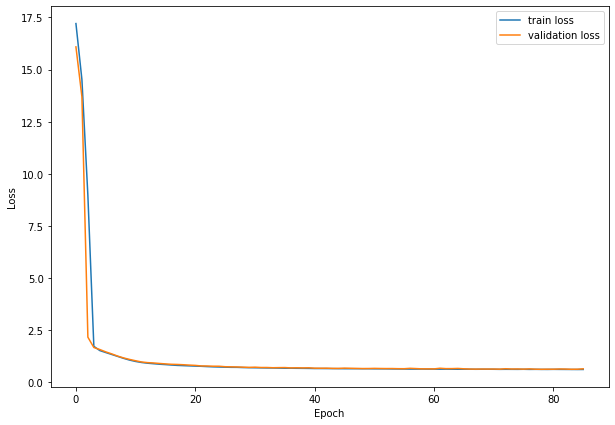

In [116]:
plt.figure(figsize=(10,7))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
# y_test2 = []
# for i in y_test['PM25']:
#   if float(i) < 30:
#     pass
#   else:
#     i = 0
#   y_test2.append(i)

In [118]:
y_pred = model.predict(x_test_scaled)

for i,y in zip(range(len(y_pred)), y_pred):
  if y < 0:
    y_pred[i] = 0
  y_pred[i] = np.round(y_pred[i], 2)

240/240 [==============================] - 0s 783us/step


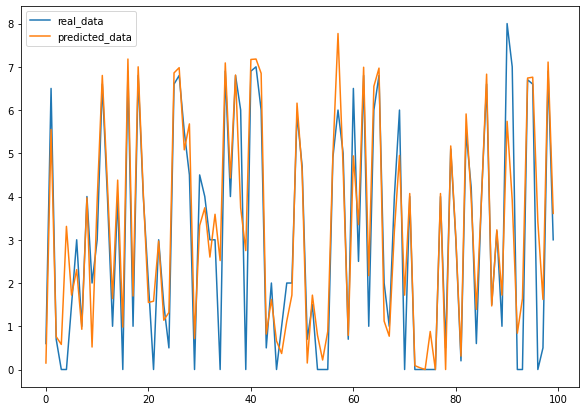

In [119]:
plt.figure(figsize=(10,7))

plt.plot(range(100), y_test[0:100], label='real_data')
plt.plot(range(100), y_pred[0:100], label='predicted_data')

plt.legend()
plt.show()

In [120]:
x_test.to_csv('/content/test_data.csv')
dump(rbs, open('/content/rbs_scaler.pkl', 'wb'))